## Импорт необходимых библиотек

In [2]:
!pip install phik -q
!pip install -Uq scikit-learn

In [3]:
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Описание необходимого исследования

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Необходимо произвести исследования в следующие этапы:

0. Загрузка данных
1. Предварительный исследовательский анализ на наличие пропусков 
2. Объединение данных
3. EDA после объединения данных
4. Предподготовка данных для модели машинного обучения 
5. Обучение различных моделей, не меньше 2х 
6. Выбор лучшей модели на основании метрики ROC-AUC, не меньше 85% 
7. Произвести анализ важности признаков, построить матрицу ошибок, ROC кривая, доп метрика accuracy
8. Вывод и рекомендации бизнесу

## Загрузка данных

In [4]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

In [5]:
RANDOM_STATE = 281024
TEST_SIZE = 0.25

## Первичный осмотр данных, заполнение пропусков

In [6]:
def function_exploration(data):
    display(data.sample(5))
    display('')
    data.info()    
    display('')
    display(data.describe())
    display(data.isna().sum())

In [7]:
function_exploration(contract_new)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
4970  9795-VOWON  2019-07-01          No        One year              Yes   
1244  2223-KAGMX  2018-08-01          No  Month-to-month               No   
2127  8035-BUYVG  2016-06-01  2019-08-01        One year              Yes   
966   4541-RMRLG  2019-04-01          No  Month-to-month               No   
1081  1751-NCDLI  2016-04-01          No  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
4970    Credit card (automatic)           24.35       185.79  
1244  Bank transfer (automatic)           19.40       380.63  
2127           Electronic check           42.35       1609.3  
966            Electronic check           19.25        192.5  
1081           Electronic check           98.85       4547.1

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


''

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<div style = 'border: solid black; padding : 20px'>
    
    Результат анализа таблицы contract_new и действия которые необходимо предпринять:
    1. Пропусков не обнаруженно
    2. Приветсти все наименования столбцом в нижнему регистру
    3. Сделать столбце таргет, где есть end_date то таргет = 1 (т.е. клиент ушел) 
    4. После заменить значения NO - датой выгрузки. Найти длительность, избавиться от stardate enddate
    5. Проверить фичу TotalCharges имеет тип object, т.е. есть не только количественные значения но и качественные?

In [8]:
#Пункт 2

contract_new.columns = contract_new.columns.str.lower()

*Приведено к нижнему регистру*

In [9]:
#Пункт 3 

contract_new['target'] = 1
contract_new_zero_target = contract_new[contract_new['enddate'] == 'No' ].index
contract_new.loc[contract_new_zero_target, 'target'] = 0

In [10]:
contract_new['enddate'].value_counts().head()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: enddate, dtype: int64

In [11]:
contract_new['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

*Проверка выполнена, таргет обозначен корректно*

In [12]:
#Пункт 4

In [13]:
contract_new.loc[contract_new_zero_target, 'enddate'] = '2020-02-01'

In [14]:
#приведем к формату даты
contract_new['enddate'] = pd.to_datetime(contract_new['enddate'])
contract_new['begindate'] = pd.to_datetime(contract_new['begindate'])

In [15]:
#найдем разницу и вытащим дни
contract_new['duration'] = contract_new['enddate'] - contract_new['begindate']
contract_new['duration'] = contract_new['duration'].dt.components['days']

In [16]:
contract_new = contract_new.drop(columns = ['enddate', 'begindate'], axis=1)

In [17]:
#пункт 5

contract_new.sort_values(by = 'totalcharges').head(2)

customerid      type paperlessbilling paymentmethod  monthlycharges  \
3331  7644-OMVMY  Two year               No  Mailed check           19.85   
4380  2520-SGTTA  Two year               No  Mailed check           20.00   

     totalcharges  target  duration  
3331                    0         0  
4380                    0         0

*Видно что totalcharges заполнен пропусками, => либо избавимся от этих данных, либо логично заполнить monthlycharges у таких пользоавтелей* 

In [18]:
index_missing_totalcharges = contract_new.query('totalcharges == " "').index
contract_new.loc[index_missing_totalcharges, 'totalcharges'] = contract_new.loc[index_missing_totalcharges, 'monthlycharges']

In [19]:
contract_new.totalcharges = contract_new.totalcharges.astype('float')

In [20]:
function_exploration(contract_new)

customerid            type paperlessbilling              paymentmethod  \
4428  5449-FIBXJ  Month-to-month               No           Electronic check   
5815  2642-DTVCO  Month-to-month              Yes           Electronic check   
3015  1498-NHTLT        Two year              Yes           Electronic check   
4242  6124-ACRHJ  Month-to-month               No               Mailed check   
263   7605-BDWDC        Two year              Yes  Bank transfer (automatic)   

      monthlycharges  totalcharges  target  duration  
4428          103.30       2299.46       0       641  
5815           85.05       1127.76       0       396  
3015           86.75       5322.98       0      1798  
4242           19.75         19.75       0        31  
263            49.85       1638.07       0       945

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


''

monthlycharges  totalcharges       target     duration
count     7043.000000   7043.000000  7043.000000  7043.000000
mean        64.761692   2115.377573     0.156325   898.555729
std         30.090047   2112.678861     0.363189   683.130510
min         18.250000     19.050000     0.000000     0.000000
25%         35.500000    436.750000     0.000000   276.000000
50%         70.350000   1343.350000     0.000000   761.000000
75%         89.850000   3236.690000     0.000000  1461.000000
max        118.750000   9221.380000     1.000000  2314.000000

customerid          0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
target              0
duration            0
dtype: int64

<div style= 'border: solid green; padding : 20px'>
    В результате данного пункта по таблице contract_new было выполенно следующее: 
    
    1. проверка на пропуски, пропусков не обнаруженно 
    2. Найдена длительность пользования у всех пользователей, избавились от времянных фичей за ненадобностью
    3. выделен таргет
    4. преобразованны полные затраты пользователем, устранены пропуски, имеет нужный формат 

In [21]:
function_exploration(personal_new)

customerID  gender  SeniorCitizen Partner Dependents
458   4237-CLSMM    Male              0     Yes         No
5995  2193-SFWQW    Male              0     Yes        Yes
455   8313-NDOIA  Female              0      No         No
5858  8241-JUIQO  Female              0      No         No
1590  7643-RCHXS  Female              0     Yes        Yes

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


''

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

<div style = 'border: solid black; padding : 20px'>
    
    Результат анализа таблицы contract_new и действия которые необходимо предпринять:
    1. Привести все значения к нижнему регистру
    2. изменить значение 0 и 1 в SeniorCitizen на да или нет 
    3. проверить пропуски в категориальных переменных

In [22]:
#Пункт 1 

personal_new.columns = personal_new.columns.str.lower()

In [23]:
#Пункт 2

personal_new.loc[personal_new.query('seniorcitizen == 0').index, 'seniorcitizen'] = 'No'
personal_new.loc[personal_new.query('seniorcitizen == 1').index, 'seniorcitizen'] = 'Yes'

In [24]:
#Пункт 3 

def exploration_categorial_features(data):
    for i in data.columns:
        if i == 'customerid':
            continue
        else:
            print(list(data[i].unique()))
            
exploration_categorial_features(personal_new)

['Female', 'Male']
['No', 'Yes']
['Yes', 'No']
['No', 'Yes']


<div style = 'border: solid green; padding: 20px'>
    В результате анализа данного пункта: 
    
    1. все наименования фичей приведены к нижнему регистру 
    2. переведены значения фичи отображающая пожилой возраст в категориальные значения
    3. проверены остальные значения на шум


In [25]:
function_exploration(internet_new)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
5111  5712-PTIWW     Fiber optic             No           No              Yes   
354   0771-WLCLA     Fiber optic            Yes           No              Yes   
5312  5626-MGTUK     Fiber optic            Yes           No               No   
3009  1767-TGTKO             DSL             No           No               No   
1922  8263-JQAIK             DSL             No           No               No   

     TechSupport StreamingTV StreamingMovies  
5111         Yes          No              No  
354          Yes         Yes             Yes  
5312          No         Yes              No  
3009          No          No              No  
1922          No          No              No

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


''

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     6992-TKNYO     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

<div style = 'border: solid black; padding : 20px'>
    
    Результат анализа таблицы internet_new и действия которые необходимо предпринять:
    1. Пропусков нет
    2. Привести все к нижнему регистру
    3. Проверить наполнения категриальных переменных

In [26]:
internet_new.columns = internet_new.columns.str.lower()

In [27]:
exploration_categorial_features(internet_new)

['DSL', 'Fiber optic']
['No', 'Yes']
['Yes', 'No']
['No', 'Yes']
['No', 'Yes']
['No', 'Yes']
['No', 'Yes']


<div style = 'border: solid green; padding: 20px'>
    В результате анализа данного пункта: 
    
    1. Пропусков не обнаруженно
    2. Все значения приведены к нижнему регистру
    3. Проверен состав категориальной фичи
    4. Записи есть не для всех пользователей, после объединения необходимо будет заполнить заглушкой

In [28]:
function_exploration(phone_new)

customerID MultipleLines
3477  1833-VGRUM           Yes
4705  2080-CAZNM           Yes
4581  1360-JYXKQ            No
2331  9137-NOQKA            No
2356  4361-FEBGN            No

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


''

customerID MultipleLines
count         6361          6361
unique        6361             2
top     8932-CZHRQ            No
freq             1          3390

customerID       0
MultipleLines    0
dtype: int64

<div style = 'border: solid black; padding : 20px'>
    
    Результат анализа таблицы internet_new и действия которые необходимо предпринять:
    1. Пропусков нет
    2. Привести все к нижнему регистру
    3. Проверить наполнения категриальных переменных

In [29]:
phone_new.columns = phone_new.columns.str.lower()

In [30]:
exploration_categorial_features(phone_new)

['No', 'Yes']


<div style = 'border: solid green; padding: 20px'>
    В результате анализа данного пункта: 
    
    1. Пропусков не обнаруженно
    2. Все значения приведены к нижнему регистру
    3. Проверен состав категориальной фичи
    4. Записи есть не для всех пользователей, после объединения необходимо будет заполнить заглушкой

<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Пропусков не обнаруженно, пустые значения заполнены 
    2. Все наименования фичей приведены к нижнему регистру
    3. Проверен состав каждой категориальной переменной 
    4. Записи есть не для всех пользователей, после объединения необходимо будет заполнить заглушкой
    5. Выделено значение таргета
    
<font size = 5><b> Переходим к объединению таблиц 

## Объединение данных

In [31]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


In [32]:
new_table = contract_new.copy()

In [33]:
new_table = new_table.merge(personal_new, how = 'left', on = 'customerid')

In [34]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   object 
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 715.3+ KB


In [35]:
new_table = new_table.merge(internet_new, how = 'left', on = 'customerid')

In [36]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   object 
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


В таблице internet_new имелась информация не о всех пользователях, поэтому в финальной таблице есть пропуски, позже заполним заглушкой 'Unknown'

In [37]:
new_table = new_table.merge(phone_new, how = 'left', on = 'customerid')

In [38]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   object 
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


В таблице internet_new имелась информация не о всех пользователях, поэтому в финальной таблице есть пропуски, позже заполним заглушкой 'Unknown'

In [39]:
new_table = new_table.fillna('Unknown')

In [40]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   object 
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   7043 non-null   object 
 13  onlinesecurity    7043 non-null   object 
 14  onlinebackup      7043 non-null   object 
 15  deviceprotection  7043 non-null   object 
 16  techsupport       7043 non-null   object 


<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Произвели объединение всех таблиц, никакие данные не потерялись, произведена проверка 
    
<font size = 5><b> Переходим к EDA, работаем с таблицей new_table

## Исследовательский и корреляционный анализ 

### Исследовательский анализ 

Перед проведением анализа, избавимся от поля customerid, т.к. данное поле уже не нужно 

In [41]:
new_table = new_table.drop(columns = 'customerid', axis = 1)

#### Исследовательский анализ количественных переменных

Исследовательский анализ колличественных переменных осуществляется построением гистограмм распределения значений и диаграмм размаха. Для большей уверенности можно построить violinplot.

In [42]:
eda_number_features = new_table.select_dtypes(include='number').columns
eda_cat_features = new_table.select_dtypes(exclude='number').columns

In [43]:
eda_number_table_melted = new_table[eda_number_features].melt(var_name='feature',
                                         value_name='value')

In [44]:
eda_fig_hist = px.histogram(
    eda_number_table_melted,
    x='value',
    color='feature',
    title='Гистограммы исследования количественных переменных',
    nbins=100,
    template='none',
    animation_frame='feature'
)

eda_fig_hist.update_xaxes(title_text='Значения следующего параметра')
eda_fig_hist.update_yaxes(title_text='частота встречаемости')
eda_fig_hist.show()

In [45]:
eda_fig_boxplot = px.box(
    eda_number_table_melted,
    x='value',
    color='feature',
    title='Диаграмма размаха для исследования количественных переменных',
    template='none',
    animation_frame='feature'
)

eda_fig_boxplot.show()

In [46]:
eda_fig_violin = px.violin(
    eda_number_table_melted,
    x='value',
    color='feature',
    title='Виолончельный график размаха для исследования количественных переменных',
    template='none',
    animation_frame='feature'
)

eda_fig_violin.show()

<div style = 'border: solid green; padding: 20px'>
    В результате EDA количественных переменных, можно сделать следующие выводы: 
    
    1. Анализ ежемесячных трат: гистограмма имеет ненормально распределение и выраженные 2 пика (значение около 0 и значение в интервале около 80), согласно анализу диаграммы размаха и виолончельной диаграммы, можно сделать вывод что выбросов нет. На последней также видны пиковые значения. 
    2. Анализ всех затрат: Гистограмма показывает распределение с явной положительной ассиметрией (сдвигом), диаграмма размаха и виолончельных график показал положительные анамалии, но данные аномалии объяснимы. Клиенты долго пользующиеся данным сервисом попали в статистиу. 
    3. Анализ распределения таргета, наблюдается дисбаланс классов. 
    4. Анализ длительности пользования: Гистограмма показывает распределение с  положительной ассиметрией (сдвигом), диаграмма размаха и виолончельных график говорят о том что выбросов нет. На конце всплеск долгопользующихся пользователей.  

#### Исследовательский анализ количественных переменных

In [47]:
def cat_science (data, features):
    for i in features: 
        plt.figure(figsize = (6,6))
        (data
        .groupby(i) [i]
        .count()
        .plot(kind='pie', autopct='%1.1f%%', title = f'Распределение критерия - {i}'))
        plt.show()

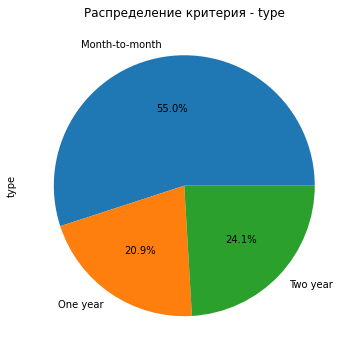

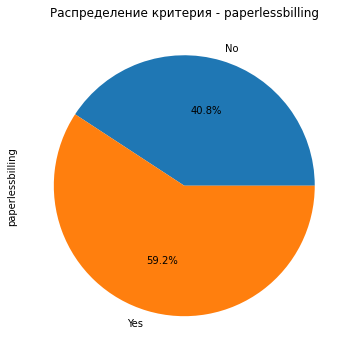

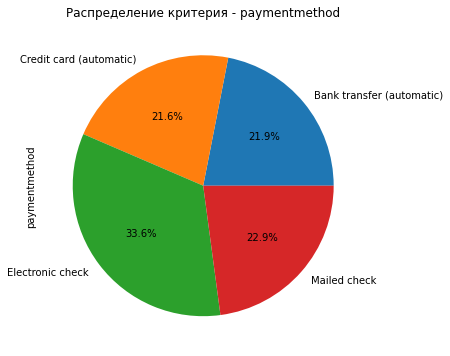

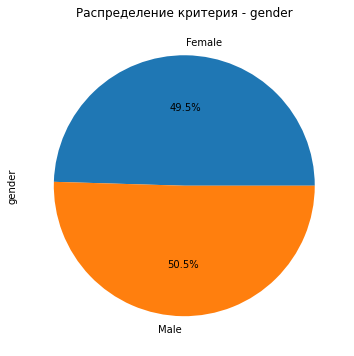

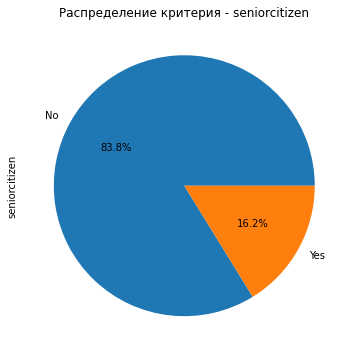

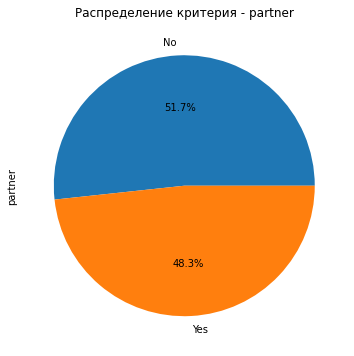

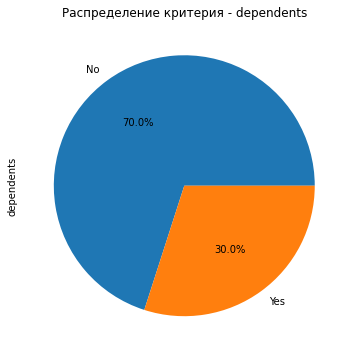

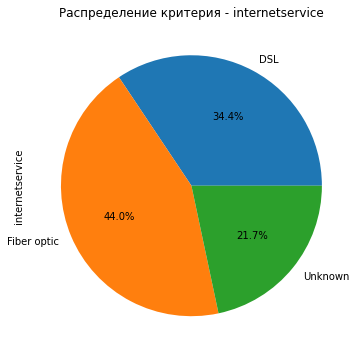

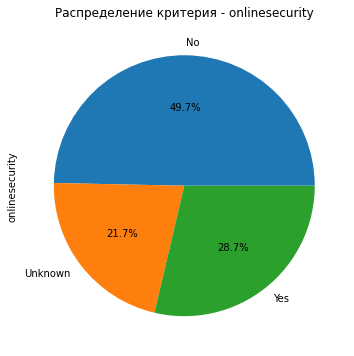

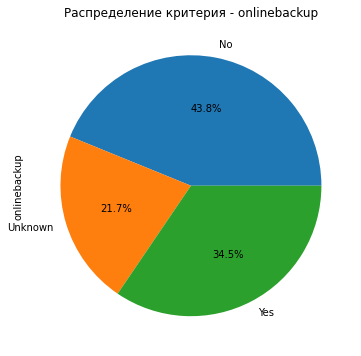

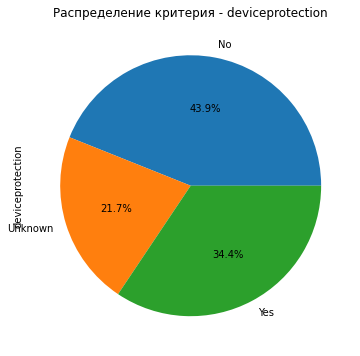

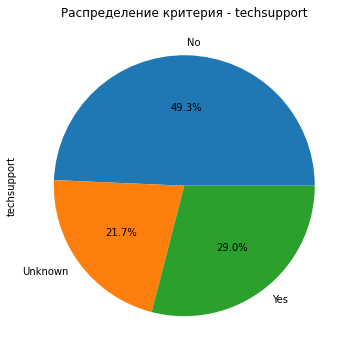

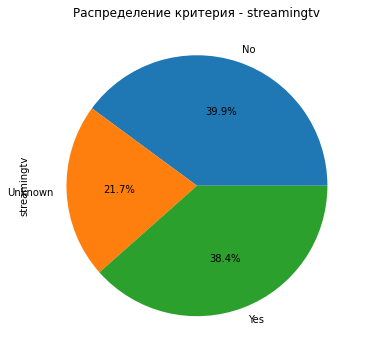

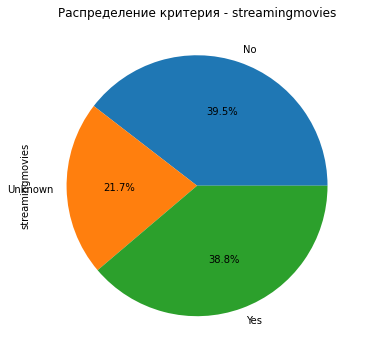

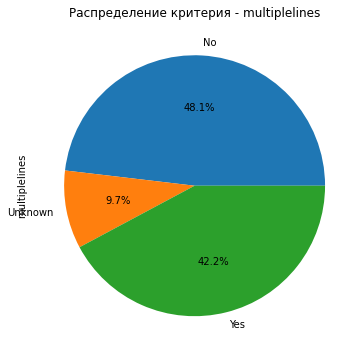

In [48]:
cat_science(new_table, eda_cat_features)

<div style = 'border: solid green; padding: 20px'>
    В результате EDA категориальных переменных, можно сделать следующие выводы: 
    
    1. Анализ типа оплат: 55% оплачивает свое пользоваение ежемесячно, по 22% в среднем оплачивают раз в год и раз в 2 года. 
    2. Электронный расчетный лист: 60% получают электронный расчетный лист. 
    3. Способ оплаты: наиболее популярный способ оплаты - электронный чек 34%, по 22 % разделили между собой Чек по почте, кредитка, трансфер банка. Последние 2 автоматически списывают деньги. 
    4. Распределение по полу: 50% мужчины 50% женщины 
    5. Пенсионеров 16% в общей массе
    6. у 50% аудитории есть супруг или супруга
    7. У 30% аудитории есть дети
    8. Наиболее популярный тип подключения Fiber optic - 44%, DSL - 35%, 22% остется неизвестным 
    9. блокировка опасных сайтов - 50% не пользуются, 29% используют, остальное неизветсно
    10. Облачное хранилище файлов для резервного копирования данных - 44% не используют, 35% используют, 22% неизвестно 
    11. Антивирус - 44% не используют, 35% используют, 22% неизвестно
    12. выделенная линия технической поддержки - 49% не используют, 22% используют, 29% неизвестно
    13. стриминговое телевидение - 40% не используют, 39% используют, 21% неизвестно
    14. каталог фильмов - 39% не используют, 39% используют, 22% неизвестно
    15. подключение телефона к нескольким линиям одновременно - 48% не используют, 42.2% используют, 9.7% неизвестно

<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Произвели исследование всех переменных, сделаны некоторые заключения выше. 
    2. Вывод можно сделать следующее: после обучения модели, необходимо оценить необходимость всех категориальных переменных (ПРОВЕРИТЬ НА МУЛЬТИКОЛЛИНЕАРНОСТЬ, т.к. есть подозрения что часть признаков повторяют друг друга)
<font size = 5><b> Переходим к корреляционному анализу

### Корреляционный анализ

Проведем корреляционный анализ, используя Спирмана, phik matrix а так же критерий VIF

In [49]:
def correlation (x, num_cols):
    display('Матрица корреляций  - Коэф. Спримана')
    
    plt.figure (figsize = (7,7))
    sns.heatmap (x.corr(method = 'spearman'), annot = True, cmap = 'cividis')
    plt.show()  
    
    display('Матрица корреляций  - phik Matrix')
    
    plt.figure (figsize = (14,14))
    sns.heatmap (x.phik_matrix(interval_cols = num_cols), annot = True, cmap = 'cividis')
    plt.show()
    
    display('VIF')
    
    x_vif = x[num_cols]
    X = add_constant (x_vif)
    vif_data = pd.Series ([variance_inflation_factor(X.values, i)
                          for i in range (X.shape[1])],
                         index = X.columns)
    display (vif_data)

'Матрица корреляций  - Коэф. Спримана'

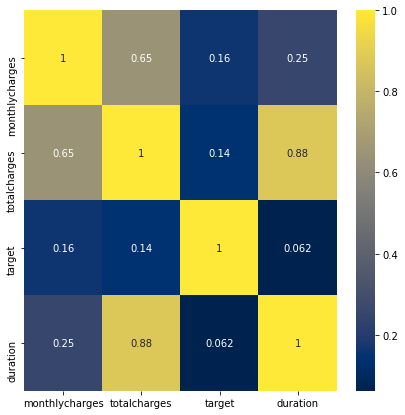

'Матрица корреляций  - phik Matrix'

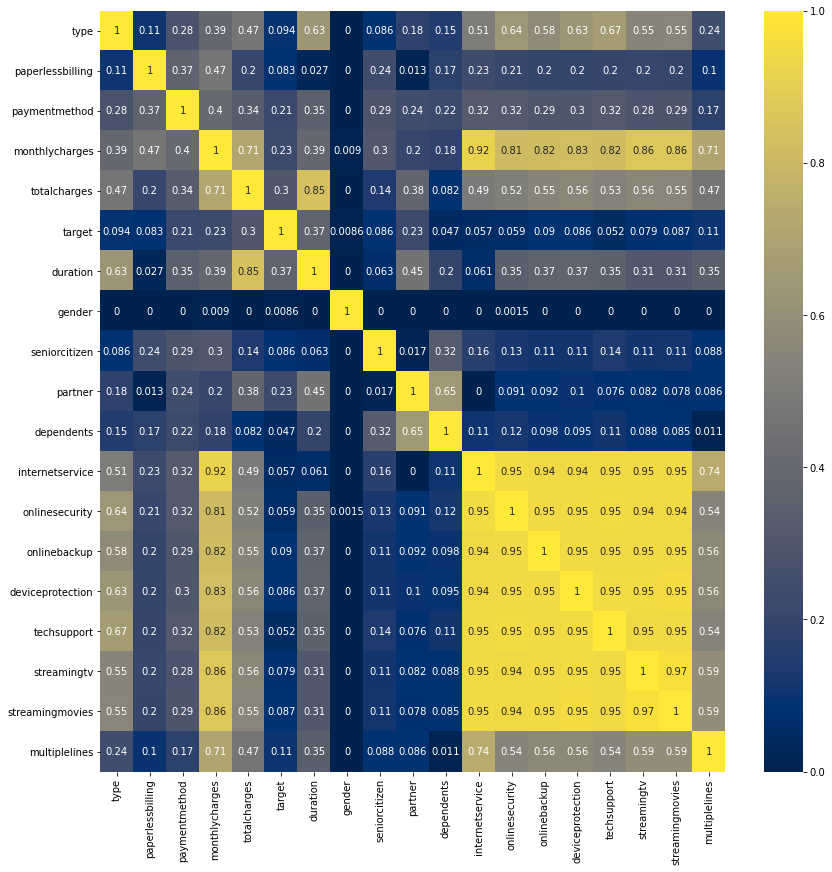

'VIF'

const             14.580704
monthlycharges     3.038772
totalcharges       8.903923
duration           5.637937
dtype: float64

In [50]:
correlation(new_table, ['monthlycharges', 'totalcharges', 'duration'])

<div style = 'border: 1px solid red; padding: 20px'>
    Результат промежуточного корреляционного анализа: 
    
    1. Признаки 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies' - имеют явно выраженную мультиколлинеарность, тем самым будут мешать в выборке. избавимся от них, оставим один, например 'onlinesecurity'

In [51]:
new_table_no_multicol = new_table.drop(columns = ['internetservice', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'], axis = 1)

'Матрица корреляций  - Коэф. Спримана'

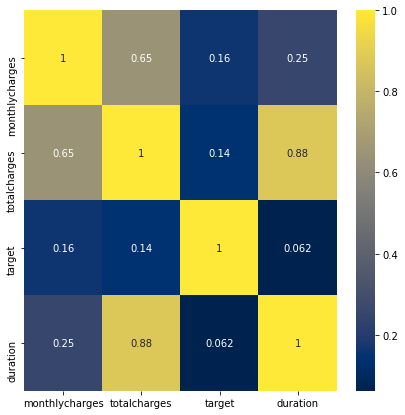

'Матрица корреляций  - phik Matrix'

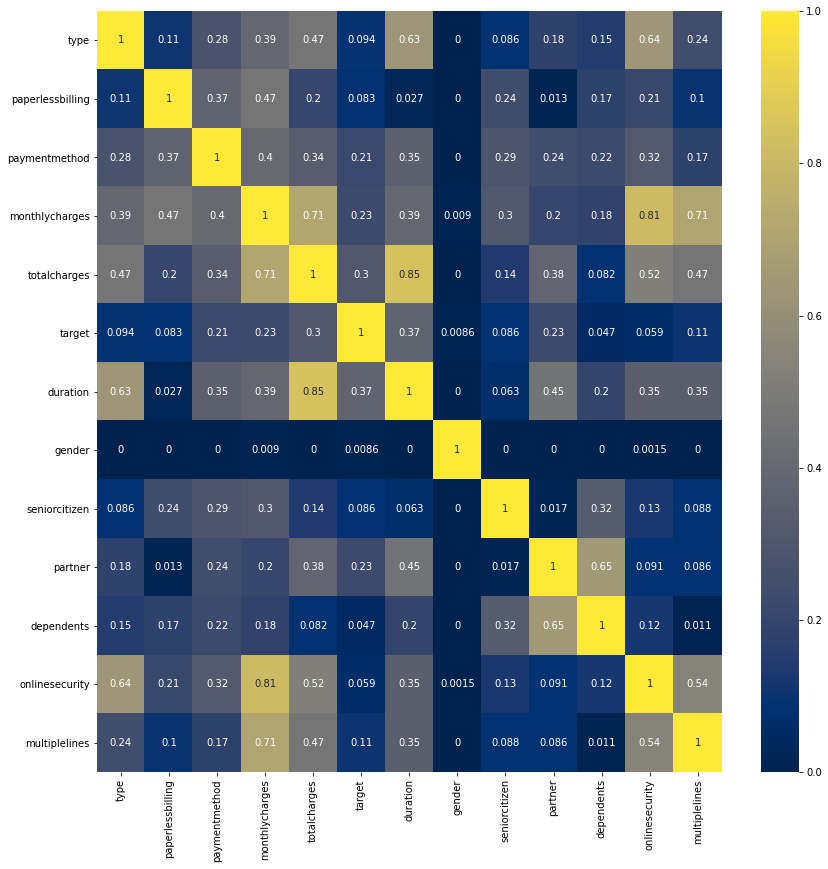

'VIF'

const             14.580704
monthlycharges     3.038772
totalcharges       8.903923
duration           5.637937
dtype: float64

In [52]:
correlation(new_table_no_multicol, ['monthlycharges', 'totalcharges', 'duration'])

<div style = 'border: 1px solid red; padding: 20px'>
    Результат промежуточного корреляционного анализа: 
    
    1. Признаки 'totalcharges' и 'duration' имеют мультиколлинеарность, избавимся от первого. Мультиколлинеарность объяснима, чем дольше пользователь пользуется сервисами, тем больше денег он заплатил

In [53]:
new_table_no_multicol = new_table_no_multicol.drop(columns = ['totalcharges'], axis = 1)

'Матрица корреляций  - Коэф. Спримана'

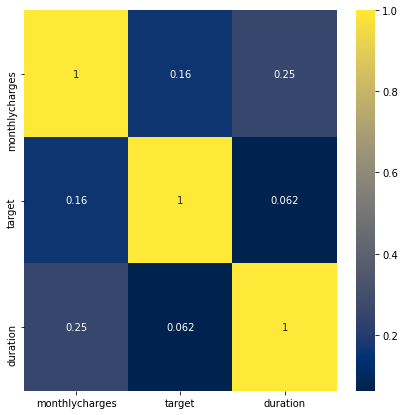

'Матрица корреляций  - phik Matrix'

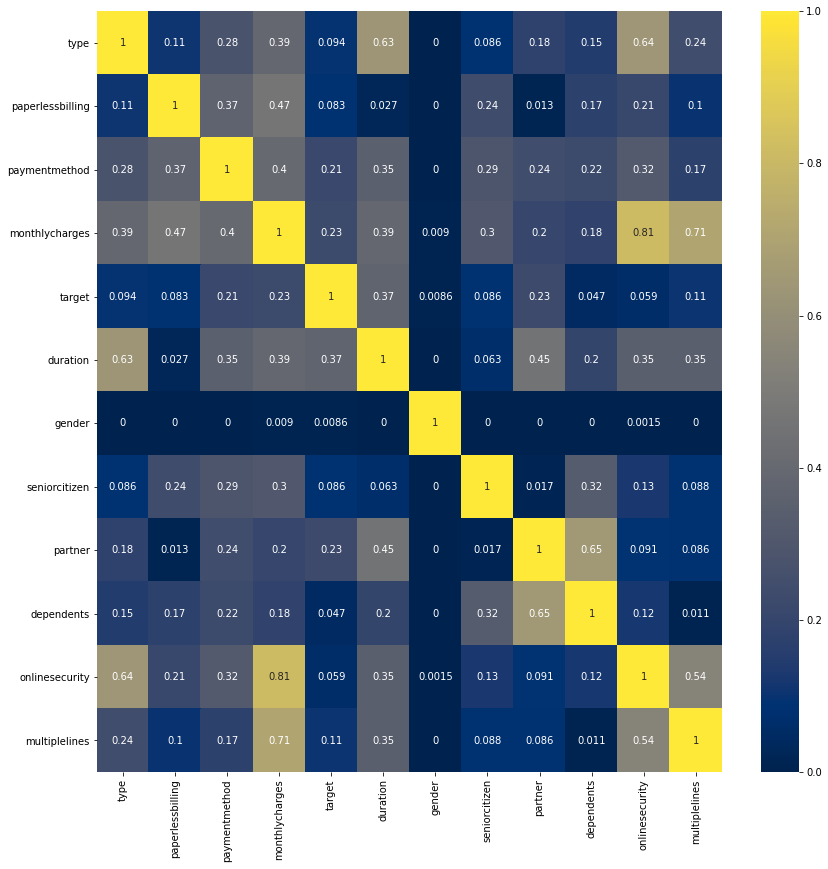

'VIF'

const             6.377573
monthlycharges    1.050888
duration          1.050888
dtype: float64

In [54]:
correlation(new_table_no_multicol, ['monthlycharges', 'duration'])

<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Произвели исследование всех переменных, обнаружена мультиколлинеарность между некторыми параметрами.  
    2. Избавились от всей возможной мультиколлинеарности
<font size = 5><b> Переходим к предподготовке данных

## Подготовка данных для обучения модели

### Проверка на явные дубликаты

In [55]:
print('Кол-во явных дубликатов в таблице -', new_table_no_multicol.duplicated().sum())

Кол-во явных дубликатов в таблице - 23


In [56]:
new_table_no_multicol = new_table_no_multicol.drop_duplicates()

In [57]:
print('Кол-во явных дубликатов в таблице -', new_table_no_multicol.duplicated().sum())

Кол-во явных дубликатов в таблице - 0


### Подготовим Трейновую и Тестовую выборки

При подготовке трейновой и тестовой выборок из-за дисбалансов классов необходимо сделать это с стратификацией

In [58]:
#Выделим таргет и выборку 

X = new_table_no_multicol.drop(columns = 'target', axis = 1)
y = new_table_no_multicol.target

In [59]:
X.head()

type paperlessbilling              paymentmethod  monthlycharges  \
0  Month-to-month              Yes           Electronic check           29.85   
1        One year               No               Mailed check           56.95   
2  Month-to-month              Yes               Mailed check           53.85   
3        One year               No  Bank transfer (automatic)           42.30   
4  Month-to-month              Yes           Electronic check           70.70   

   duration  gender seniorcitizen partner dependents onlinesecurity  \
0        31  Female            No     Yes         No             No   
1      1036    Male            No      No         No            Yes   
2       123    Male            No      No         No            Yes   
3      1371    Male            No      No         No            Yes   
4       153  Female            No      No         No             No   

  multiplelines  
0       Unknown  
1            No  
2            No  
3       Unknown  
4            No

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(),
                                                    y,
                                                    random_state=RANDOM_STATE,
                                                    test_size=TEST_SIZE,
                                                    stratify = y
                                                   )

### Кодировка и масштабирование данных

**Проверим различные способы кодирования данных на результат расчета модели**

#### Подготовка данных для линейных моделей (только с использованием OHE)

In [61]:
number_features_linear_models = X_train.select_dtypes(include = 'number').columns
cat_features_linear_models = X_train.select_dtypes(exclude = 'number').columns

In [62]:
ohe_pipeline = Pipeline(steps =
                       [
                           ('SimpleImputer_ohe',
                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('ohe',
                           OneHotEncoder (drop = 'first', handle_unknown = 'ignore', sparse_output = False)
                           )
                       ])

In [63]:
data_preprocessor = ColumnTransformer(transformers = 
                                     [
                                         ('ohe', ohe_pipeline, cat_features_linear_models),
                                         ('num', StandardScaler(), number_features_linear_models)
                                     ],
                                     remainder = 'passthrough')



X_train_transformed = data_preprocessor.fit_transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

ohe_features_name = data_preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(cat_features_linear_models)
num_features_name = number_features_linear_models  
all_features = np.concatenate([ohe_features_name, num_features_name])


X_train_transformed_linear_model = pd.DataFrame(X_train_transformed, columns=all_features)
X_test_transformed_linear_model = pd.DataFrame(X_test_transformed, columns=all_features)

display(X_train_transformed_linear_model.sample(3))
display(X_test_transformed_linear_model.sample(3))

type_One year  type_Two year  paperlessbilling_Yes  \
1556            0.0            1.0                   1.0   
5252            0.0            0.0                   0.0   
3552            0.0            0.0                   0.0   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
1556                                    0.0                             0.0   
5252                                    0.0                             0.0   
3552                                    0.0                             1.0   

      paymentmethod_Mailed check  gender_Male  seniorcitizen_Yes  partner_Yes  \
1556                         0.0          0.0                0.0          1.0   
5252                         0.0          1.0                0.0          1.0   
3552                         0.0          1.0                0.0          1.0   

      dependents_Yes  onlinesecurity_Unknown  onlinesecurity_Yes  \
1556             1.0                     0.0                 1.0   
5252             0.0                     1.0                 0.0   
3552             1.0                     0.0                 0.0   

      multiplelines_Unknown  multiplelines_Yes  monthlycharges  duration  
1556                    0.0                1.0        0.419232 -0.277989  
5252                    0.0                0.0       -1.477457  0.343818  
3552                    0.0                0.0        0.542784 -0.682750

type_One year  type_Two year  paperlessbilling_Yes  \
571             0.0            0.0                   1.0   
438             0.0            0.0                   0.0   
1408            0.0            1.0                   1.0   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
571                                     0.0                             1.0   
438                                     0.0                             0.0   
1408                                    0.0                             0.0   

      paymentmethod_Mailed check  gender_Male  seniorcitizen_Yes  partner_Yes  \
571                          0.0          1.0                1.0          1.0   
438                          1.0          1.0                1.0          0.0   
1408                         0.0          1.0                0.0          1.0   

      dependents_Yes  onlinesecurity_Unknown  onlinesecurity_Yes  \
571              0.0                     0.0                 1.0   
438              0.0                     0.0                 0.0   
1408             1.0                     0.0                 0.0   

      multiplelines_Unknown  multiplelines_Yes  monthlycharges  duration  
571                     0.0                1.0        1.000259  0.257293  
438                     0.0                1.0        0.305697 -0.902729  
1408                    0.0                1.0       -0.043253  0.789642

#### Подготовка данных для нелинейных моделей (с использованием OHE и ORD

In [64]:
number_features_all_models = X_train.select_dtypes(include = 'number').columns
OHE_cat_features_all_models = ['paperlessbilling', 'gender', 'seniorcitizen', 'partner', 'dependents', 'onlinesecurity', 'multiplelines']
ORD_cat_features_all_models = ['type', 'paymentmethod']

In [65]:
ohe_pipeline = Pipeline(steps =
                       [
                           ('SimpleImputer_ohe',
                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('ohe',
                           OneHotEncoder (drop = 'first', handle_unknown = 'ignore', sparse_output = False)
                           )
                       ])

ord_pipeline = Pipeline(steps = 
                       [
                           ('SimpleImputer_before_ord',
                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('ord',
                            OrdinalEncoder(categories = [ 
                                                        ['Month-to-month', 'One year', 'Two year'],
                                                        ['Mailed check', 'Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)']],
                                          handle_unknown = 'use_encoded_value',
                                          unknown_value = np.nan)
                           ),
                           ('SimpleImputer_after_ord', 
                            SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                       ])

In [66]:
data_preprocessor = ColumnTransformer(transformers = 
                                     [
                                         ('ohe', ohe_pipeline, OHE_cat_features_all_models),
                                         ('ord', ord_pipeline, ORD_cat_features_all_models),
                                         ('num', StandardScaler(), number_features_all_models)
                                     ],
                                     remainder = 'passthrough')



X_train_transformed = data_preprocessor.fit_transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

ohe_features_name = data_preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(OHE_cat_features_all_models)
ord_features_name = ORD_cat_features_all_models  
num_features_name = number_features_all_models  
all_features = np.concatenate([ohe_features_name, ord_features_name, num_features_name])

X_train_transformed_all_model = pd.DataFrame(X_train_transformed, columns=all_features)
X_test_transformed_all_model = pd.DataFrame(X_test_transformed, columns=all_features)

display(X_train_transformed_all_model.sample(3))
display(X_test_transformed_all_model.sample(3))

paperlessbilling_Yes  gender_Male  seniorcitizen_Yes  partner_Yes  \
2072                   0.0          1.0                0.0          1.0   
4615                   1.0          1.0                0.0          1.0   
3009                   0.0          0.0                0.0          1.0   

      dependents_Yes  onlinesecurity_Unknown  onlinesecurity_Yes  \
2072             1.0                     0.0                 1.0   
4615             1.0                     1.0                 0.0   
3009             1.0                     0.0                 0.0   

      multiplelines_Unknown  multiplelines_Yes  type  paymentmethod  \
2072                    0.0                0.0   2.0            0.0   
4615                    0.0                0.0   2.0            0.0   
3009                    1.0                0.0   1.0            0.0   

      monthlycharges  duration  
2072        1.454396  1.461311  
4615       -1.462430  1.685689  
3009       -0.791243  0.257293

paperlessbilling_Yes  gender_Male  seniorcitizen_Yes  partner_Yes  \
770                    1.0          0.0                0.0          1.0   
1642                   0.0          0.0                1.0          0.0   
1188                   1.0          0.0                0.0          1.0   

      dependents_Yes  onlinesecurity_Unknown  onlinesecurity_Yes  \
770              1.0                     1.0                 0.0   
1642             0.0                     0.0                 1.0   
1188             0.0                     1.0                 0.0   

      multiplelines_Unknown  multiplelines_Yes  type  paymentmethod  \
770                     0.0                0.0   1.0            1.0   
1642                    0.0                1.0   1.0            2.0   
1188                    0.0                1.0   2.0            2.0   

      monthlycharges  duration  
770        -1.475787  1.015487  
1642        1.282425  0.880566  
1188       -1.288790  1.819143

<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Подготовили данные с разными параметрами масштабирования
    2. проверим результативность моделей на различных масштабируемых данных
<font size = 5><b> Переходим к обучению моделей

## Обучение моделей, проверка качества

### Обучение линейных моделей

Хоть мы и создали датасет предполагая, что на нем будут тестироваться модели линейные, мы проверим все

In [69]:
pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', LogisticRegression(random_state = RANDOM_STATE))
    ])

params = [
    {
         'model': [LogisticRegression(random_state = RANDOM_STATE,
                                      solver = 'liblinear'
                                     )],
        'model__penalty': ['l1', 'l2'],
        'model__C': range(5, 15, 5)
    },
    {
        'model' : [SVC (random_state = RANDOM_STATE, probability=True)],
        'model__C': range (1, 20, 10),
        'model__kernel' : ['linear', 'poly', 'rbf'] 
        
    },
    {
        'model' : [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'model__max_depth' : range (1, 15, 5),
        'model__min_samples_split' : range(2, 15, 5)
    },
    {
        'model' : [KNeighborsClassifier(n_jobs = -1)],
        'model__n_neighbors' : range(1, 20, 8)
    },
    {
        'model' : [RandomForestClassifier(random_state = RANDOM_STATE)],
        'model__n_estimators' : [100, 200, 300],
        'model__max_depth' : range (1, 15, 7),
        'model__min_samples_split' : range(2, 15, 7),
        'model__max_features': range(1, 15, 7)
    },
    {
        'model' : [CatBoostClassifier(random_state = RANDOM_STATE)],
        'model__iterations': [50, 150],
        'model__depth': range(5, 15, 7),
        'model__learning_rate': [0.01, 0.1]
    },
    {
        'model': [LGBMClassifier(random_state = RANDOM_STATE)],
        'model__max_depth': [10, 100],
        'model__num_leaves': [50, 150]
    }
]

In [70]:
%time
GridSearch = GridSearchCV (estimator = pipeline,
                         param_grid = params,
                         cv = 5,
                         scoring = 'roc_auc',
                         n_jobs = -1)

GridSearch.fit(X_train_transformed_linear_model, y_train)

print(f'Лучшая модель: {GridSearch.best_estimator_}')
print(F'Метрика ROC-AUC на трейновой выборке: (ROC-AUC) {GridSearch.best_score_}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
0:	learn: 0.6881335	total: 47.9ms	remaining: 2.35s
1:	learn: 0.6832539	total: 49.4ms	remaining: 1.18s
2:	learn: 0.6786604	total: 50.4ms	remaining: 790ms
3:	learn: 0.6741017	total: 51.4ms	remaining: 592ms
4:	learn: 0.6693712	total: 52.5ms	remaining: 473ms
5:	learn: 0.6647549	total: 53.5ms	remaining: 392ms
6:	learn: 0.6601007	total: 54.5ms	remaining: 335ms
7:	learn: 0.6555633	total: 55.5ms	remaining: 292ms
8:	learn: 0.6513032	total: 56.5ms	remaining: 257ms
9:	learn: 0.6473429	total: 57.5ms	remaining: 230ms
10:	learn: 0.6433638	total: 58.6ms	remaining: 208ms
11:	learn: 0.6390976	total: 59.7ms	remaining: 189ms
12:	learn: 0.6351275	total: 60.8ms	remaining: 173ms
13:	learn: 0.6308289	total: 61.8ms	remaining: 159ms
14:	learn: 0.6269652	total: 62.8ms	remaining: 146ms
15:	learn: 0.6230371	total: 63.8ms	remaining: 136ms
16:	learn: 0.6189728	total: 64.8ms	remaining: 126ms
17:	learn: 0.6155006	total: 65.8ms	remaining: 117ms
18:	learn:

### Обучение нелинейных моделей

In [71]:
%time
GridSearch2 = GridSearchCV (estimator = pipeline,
                         param_grid = params,
                         cv = 5,
                         scoring = 'roc_auc',
                         n_jobs = -1)

GridSearch2.fit(X_train_transformed_all_model, y_train)

print(f'Лучшая модель: {GridSearch2.best_estimator_}')
print(F'Метрика ROC-AUC на трейновой выборке: (ROC-AUC) {GridSearch2.best_score_}')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
0:	learn: 0.6878530	total: 1.23ms	remaining: 60.5ms
1:	learn: 0.6828189	total: 2.39ms	remaining: 57.4ms
2:	learn: 0.6778833	total: 3.58ms	remaining: 56.1ms
3:	learn: 0.6729059	total: 4.63ms	remaining: 53.3ms
4:	learn: 0.6680580	total: 5.76ms	remaining: 51.8ms
5:	learn: 0.6636881	total: 6.33ms	remaining: 46.4ms
6:	learn: 0.6592428	total: 7.51ms	remaining: 46.1ms
7:	learn: 0.6547481	total: 8.76ms	remaining: 46ms
8:	learn: 0.6501418	total: 9.8ms	remaining: 44.7ms
9:	learn: 0.6456749	total: 10.9ms	remaining: 43.6ms
10:	learn: 0.6412613	total: 12ms	remaining: 42.5ms
11:	learn: 0.6369048	total: 13.1ms	remaining: 41.5ms
12:	learn: 0.6330651	total: 13.6ms	remaining: 38.8ms
13:	learn: 0.6293713	total: 14.6ms	remaining: 37.5ms
14:	learn: 0.6252068	total: 15.7ms	remaining: 36.7ms
15:	learn: 0.6215919	total: 16.8ms	remaining: 35.8ms
16:	learn: 0.6180014	total: 17.6ms	remaining: 34.2ms
17:	learn: 0.6145032	total: 18.5ms	remaining: 32.9

<div style = 'border: 1px solid green; padding: 20px'>
    Результат промежуточного анализа обучения моделей: 
    
    1. Проведено обучение на данных закодированных по разному
    2. на кросс валидации получено лучшее качество на следующих данных: X_train_transformed_all_model, в дальнейшем будем использовать этот датасет 
    3. Проверим качество предсказаний на тестовой выборке

In [72]:
best_model = GridSearch2.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_transformed_all_model)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test,y_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9145503685503685


In [73]:
y_pred_accuracy = best_model.predict(X_test_transformed_all_model)
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test,y_pred_accuracy)}')

Метрика accuracy на тестовой выборке: 0.905982905982906


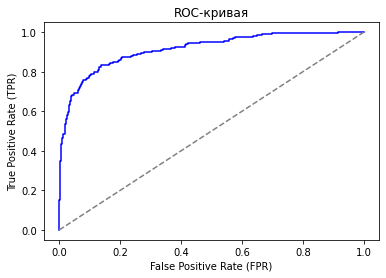

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # линия случайных предсказаний
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.show()

<div style = 'border: solid orange; padding: 20px'>
    В результате пункта: 
    
    1. Достигли на кросс-валидации хорошего критерия успеха = 86.7%, а на тестовой выборке 91.4%, что говорит о том что модель удовлетворяет условиям
    2. Для выкатки в прод будем использовать данных кодируемые не только OHE, но и ORD 
    3. построена ROC-кривая
    4. Accuraccy = 90.5%
    
    P.S. количество гипперпараметров было больше, но я их уменьшил у заведомо проигравших для ускорения процесса расчета. 
    
<font size = 5><b> Переходим к изучению важности признаков

## Изучение важности признаков 

### Произведем анализ с использованием матрицы ошибок

Матрица ошибок для порога - 0.3


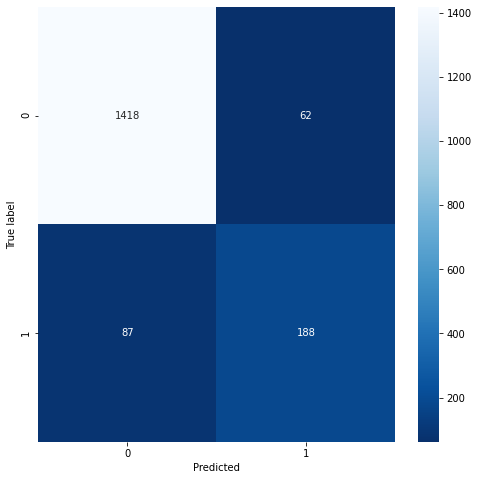

Матрица ошибок для порога - 0.4


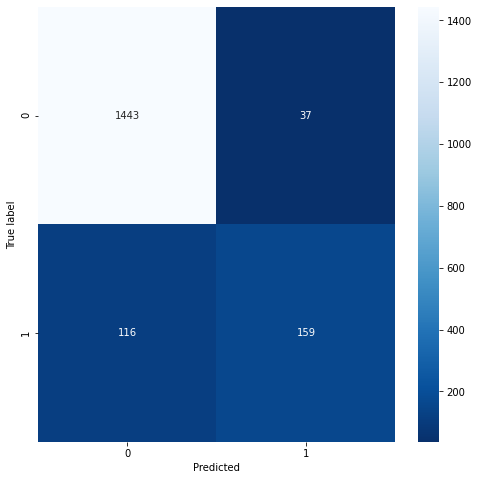

Матрица ошибок для порога - 0.5


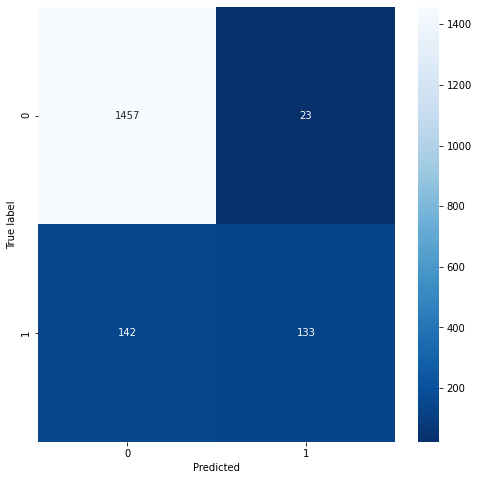

Матрица ошибок для порога - 0.6


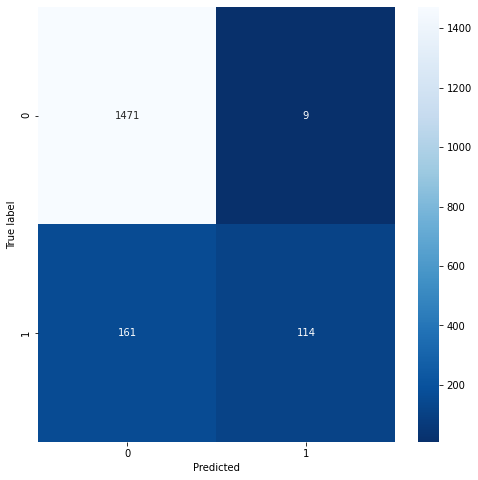

Матрица ошибок для порога - 0.7


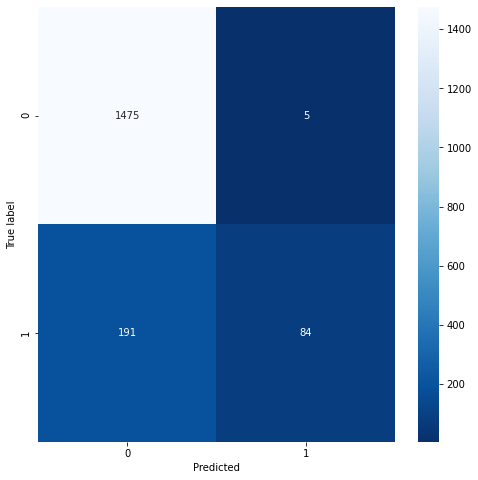

Матрица ошибок для порога - 0.8


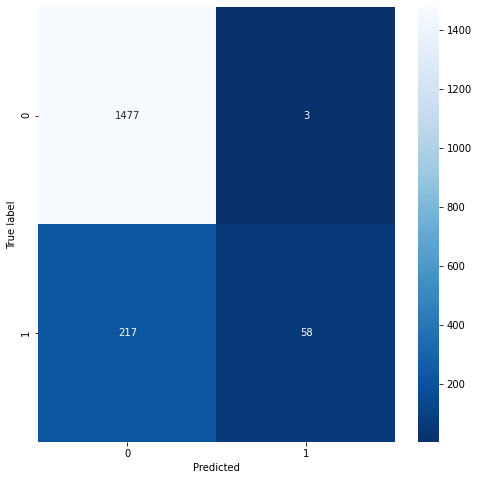

Матрица ошибок для порога - 0.9


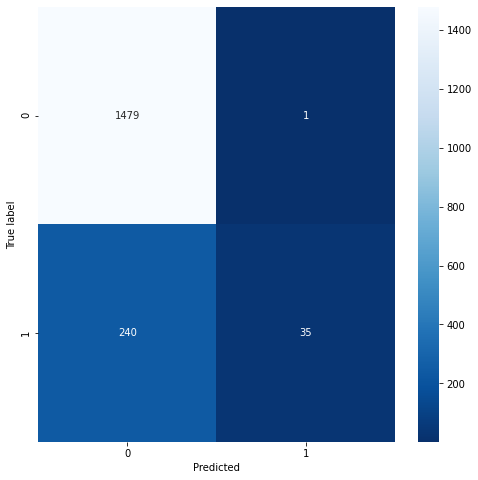

In [75]:
for i in range (3, 10):
    cm = confusion_matrix(y_test, y_pred_proba>i/10)
    print(f'Матрица ошибок для порога - {i/10}')
    plt.figure (figsize = (8,8))
    sns.heatmap (cm, annot = True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted');
    plt.show()

<div style = 'border: 1px solid green; padding: 20px'>
    Результат промежуточного анализа матриц ошибок: 
    
    1. В зависимости от бизнес задачи можно влиять определенным порогом на результат работы модели, а именно, если нужно уменьшать количество ложноположительных ответов или наоборот ложноотрицательных. 
   

### Изучение важности признаков

In [76]:
final_model = best_model.named_steps ['model']

In [77]:
feature_importances_table = pd.DataFrame({'feature_name' : X_train_transformed_all_model.columns, 'importance' : final_model.feature_importances_})

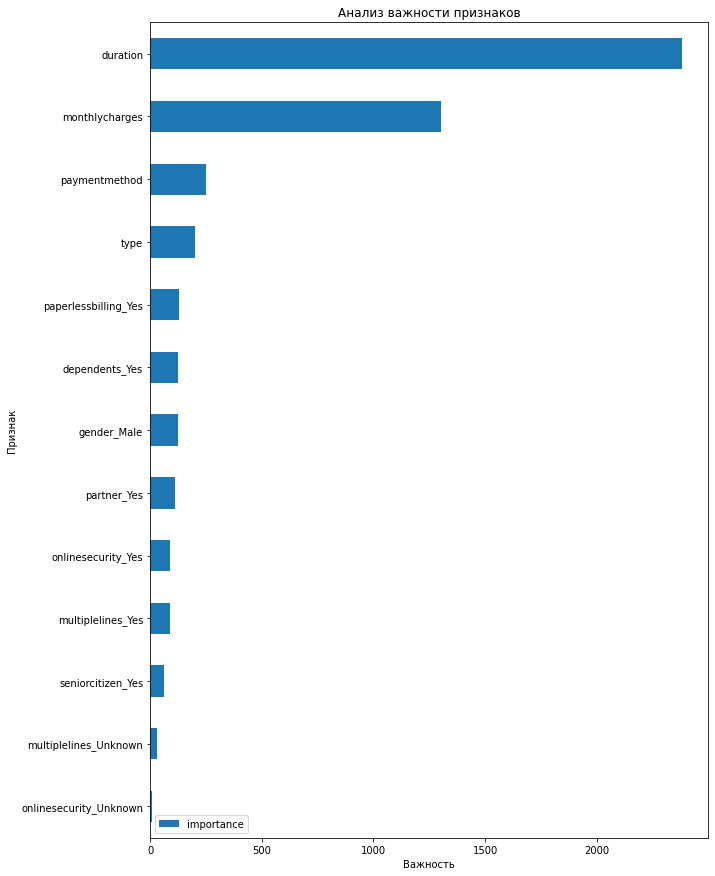

In [78]:
feature_importances_table\
.sort_values(by = 'importance', ascending = True)\
.plot(x='feature_name', y='importance', kind='barh', figsize=(10, 15))

plt.title('Анализ важности признаков')
plt.ylabel('Признак')
plt.xlabel('Важность')
plt.show()

<div style = 'border: 1px solid green; padding: 20px'>
    Результат промежуточного анализа важности признаков:  
    
    1. Наиболее важный признак - длительность нахождения с команией и ежемесячный платеж

## Вывод по результату работы

Были проделаны следующие пункты в которых: 

0. Загрузка данных - загруженны 4 файла


1. Предварительный исследовательский анализ на наличие пропусков - Пропусков не обнаруженно, пустые значения заполнены либо заглушкой, либо объяснимым значением, Все наименования признаков приведены к нижнему регистру, Проверен состав каждой категориальной переменной, Выделено значение таргета


2. Объединение данных, объеденены 4 таблицы, пропуски заполнены заглушкой


3. EDA после объединения данных
    **Анализ количественных переменных:** 
    1. Анализ ежемесячных трат: гистограмма имеет ненормально распределение и выраженные 2 пика (значение около 0 и значение в интервале около 80), согласно анализу диаграммы размаха и виолончельной диаграммы, можно сделать вывод что выбросов нет. На последней также видны пиковые значения. 
    2. Анализ всех затрат: Гистограмма показывает распределение с явной положительной ассиметрией (сдвигом), диаграмма размаха и виолончельных график показал положительные анамалии, но данные аномалии объяснимы. Клиенты долго пользующиеся данным сервисом попали в статистиу. 
    3. Анализ распределения таргета, наблюдается дисбаланс классов. 
    4. Анализ длительности пользования: Гистограмма показывает распределение с  положительной ассиметрией (сдвигом), диаграмма размаха и виолончельных график говорят о том что выбросов нет. На конце всплеск долгопользующихся пользователей. 
    **Анализ качественных переменных:**
    1. Анализ типа оплат: 55% оплачивает свое пользоваение ежемесячно, по 22% в среднем оплачивают раз в год и раз в 2 года. 
    2. Электронный расчетный лист: 60% получают электронный расчетный лист. 
    3. Способ оплаты: наиболее популярный способ оплаты - электронный чек 34%, по 22 % разделили между собой Чек по почте, кредитка, трансфер банка. Последние 2 автоматически списывают деньги. 
    4. Распределение по полу: 50% мужчины 50% женщины 
    5. Пенсионеров 16% в общей массе
    6. у 50% аудитории есть супруг или супруга
    7. У 30% аудитории есть дети
    8. Наиболее популярный тип подключения Fiber optic - 44%, DSL - 35%, 22% остется неизвестным 
    9. блокировка опасных сайтов - 50% не пользуются, 29% используют, остальное неизветсно
    10. Облачное хранилище файлов для резервного копирования данных - 44% не используют, 35% используют, 22% неизвестно 
    11. Антивирус - 44% не используют, 35% используют, 22% неизвестно
    12. выделенная линия технической поддержки - 49% не используют, 22% используют, 29% неизвестно
    13. стриминговое телевидение - 40% не используют, 39% используют, 21% неизвестно
    14. каталог фильмов - 39% не используют, 39% используют, 22% неизвестно
    15. подключение телефона к нескольким линиям одновременно - 48% не используют, 42.2% используют, 9.7% неизвестно
    **Корреляционный анализ:**
    1. Произвели исследование всех переменных, обнаружена мультиколлинеарность между некторыми параметрами (Признаки 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies' - имеют явно выраженную мультиколлинеарность, тем самым будут мешать в выборке. избавимся от них, оставим один, например 'onlinesecurity').  
    2. Избавились от всей возможной мультиколлинеарности
    
    
4. Предподготовка данных для модели машинного обучения - подготовили 2 датасета с различным типом кодирования, для определения лучшего при моделировании


5. Обучение различных моделей, не меньше 2х - Рассмотрели следующие модели: Логическая регрессия, SVM, Дерево решения, К ближайших соседей, Рандомный лес, Catboost, LGBM. Лучшей моделью показала себя на кросс валидации (5эпох) LGBM. Датасет выбран 2й с OHE и ORD


6. Выбор лучшей модели на основании метрики ROC-AUC, не меньше 85% - проведено тестирование на тестовой выборке ROC-AUC 91.4 %, построена ROC-кривая, Accuraccy = 90.5%


7. Произвести анализ важности признаков, построить матрицу ошибок - Наиболее важный признак - длительность нахождения с команией и ежемесячный платеж. Показанно, что матрицей ошибок можем регулировать колчество полученных ошибок. 


8. Вывод и рекомендации бизнесу - Необходимо предлагать промокоды/скидки пользователям с большим ежемесячным платежом и долгонаходящимся с бизнесом, они вероятнее всего перейдут к другим. 